Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time
import wget

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
tf.__version__

'2.16.1'

### Load Data from fifty one

In [51]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    max_samples=100,
    seed=51,
    shuffle=True,
)

session = fo.launch_app(dataset.view())
session.view = dataset.view()

Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-v7-validation-100'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [7]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv


Saved under train-annotations-bbox.csv


In [5]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [6]:
!python -m wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [4]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [5]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [7]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Plot Bounding box

In [9]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (1280, 960, 3)
Coordinates: (316, 496), (717, 1036)


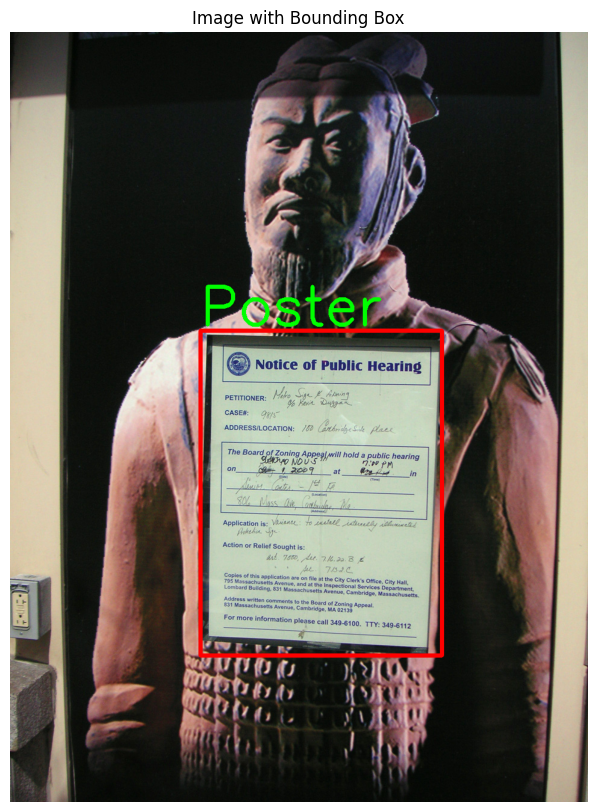

Image: (4592, 3056, 3)
Coordinates: (0, 0), (3053, 3974)


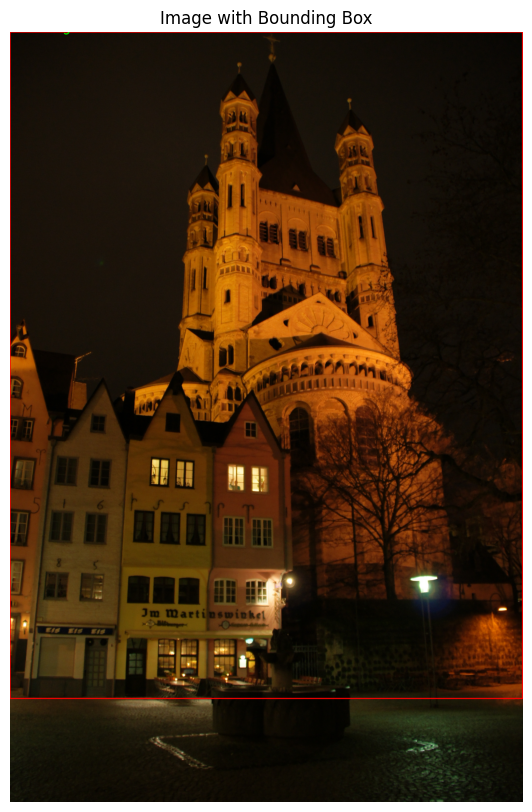

Image: (1920, 2560, 3)
Coordinates: (652, 51), (1728, 1678)


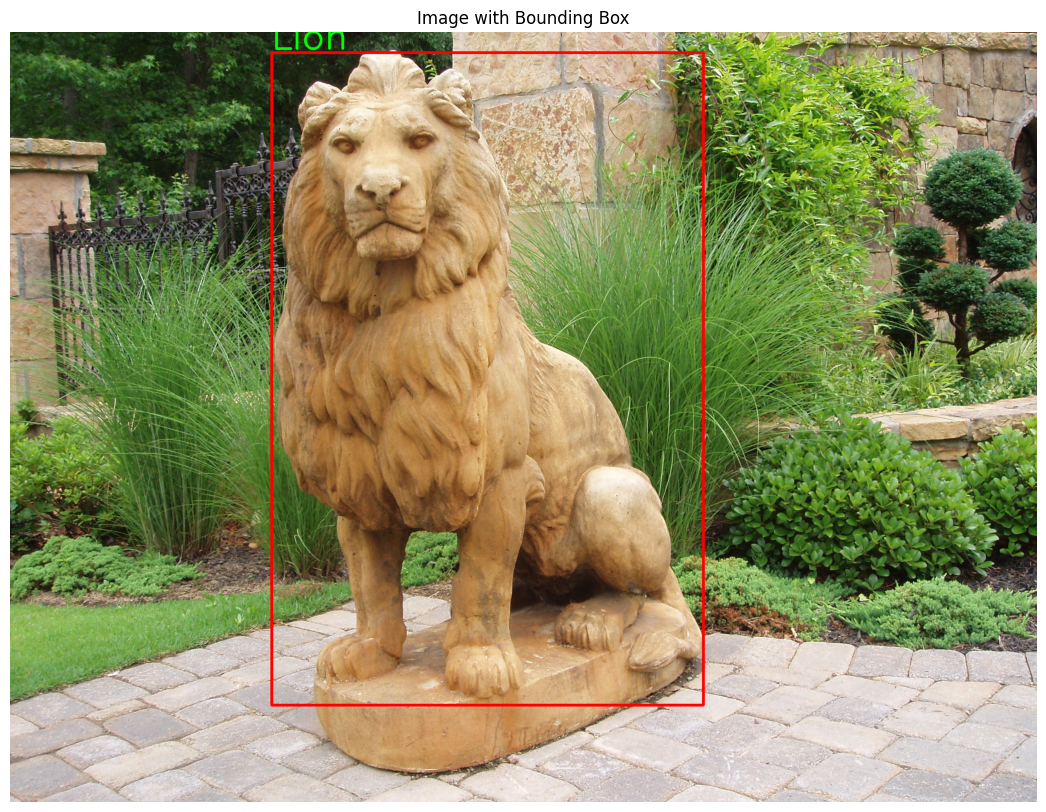

Image: (3508, 2480, 3)
Coordinates: (359, 1179), (2192, 3233)


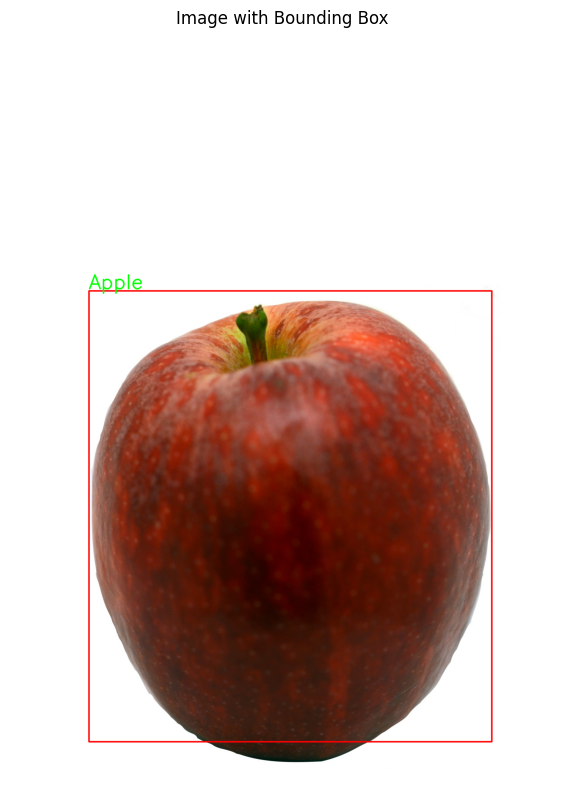

Image: (1944, 2592, 3)
Coordinates: (573, 285), (2159, 1624)


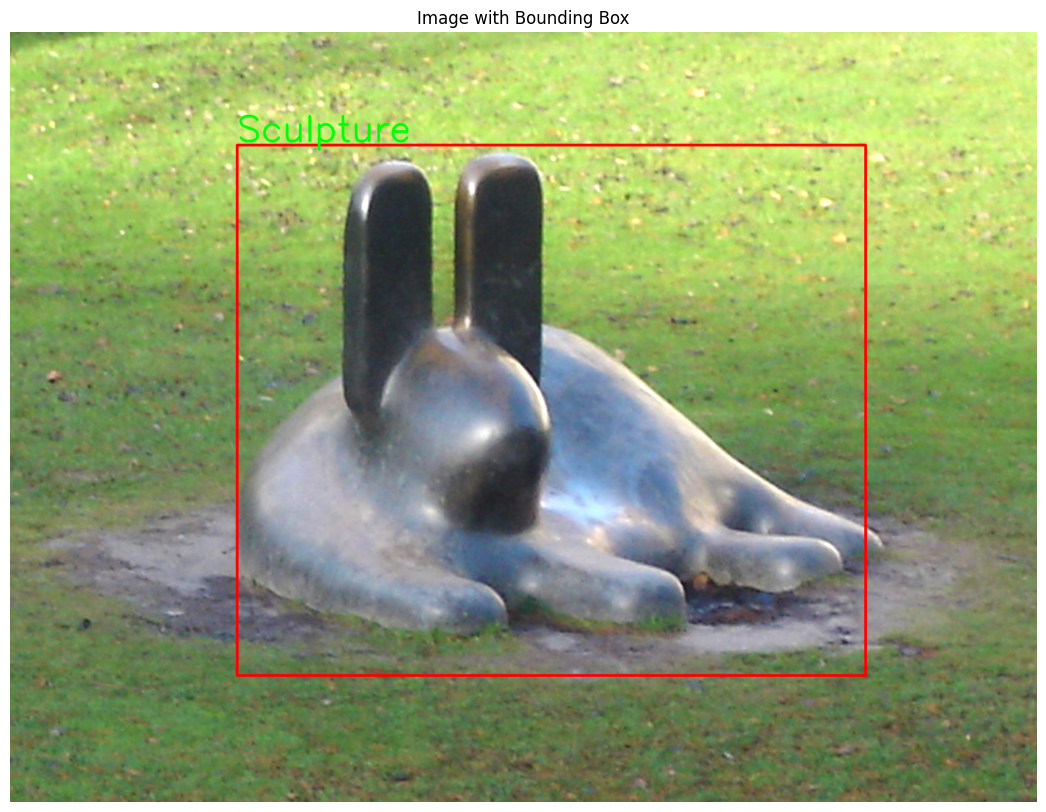

In [11]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car. We just extract 1000 images for each class from the whole dataset.

In [12]:
class_descriptions.loc[class_descriptions[1].isin(['Airplane', 'Aircraft', 'Bird'])]

0         1
21   /m/015p6      Bird
467  /m/0cmf2  Airplane
571   /m/0k5j  Aircraft

In [13]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
person_pd = class_descriptions[class_descriptions[1]=='Airplane']
phone_pd = class_descriptions[class_descriptions[1]=='Aircraft']
car_pd = class_descriptions[class_descriptions[1]=='Bird']

label_name_person = person_pd[0].values[0]
label_name_phone = phone_pd[0].values[0]
label_name_car = car_pd[0].values[0]

**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [14]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
phone_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_phone]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]

In [15]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d phones in the dataset' %(len(phone_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
person_img_id = person_bbox['ImageID']
phone_img_id = phone_bbox['ImageID']
car_img_id = car_bbox['ImageID']

There are 21285 persons in the dataset
There are 1898 phones in the dataset
There are 47921 cars in the dataset


In [16]:
person_img_id = np.unique(person_img_id)
phone_img_id = np.unique(phone_img_id)
car_img_id = np.unique(car_img_id)
print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain phones' % (len(phone_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))

There are 12003 images which contain persons
There are 1143 images which contain phones
There are 18525 images which contain cars


We just randomly pick 1000 images in here.

In [17]:
# here I've chosen only 10 images for speed, change it to your liking
n = 10
subperson_img_id = random.sample(list(person_img_id), n)
subphone_img_id = random.sample(list(phone_img_id), n)
subcar_img_id = random.sample(list(car_img_id), n)

In [18]:
subperson_pd = images_boxable.loc[images_boxable['ImageID'].isin(subperson_img_id)]
subphone_pd = images_boxable.loc[images_boxable['ImageID'].isin(subphone_img_id)]
subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]

In [19]:
subperson_pd.shape

(10, 12)

In [20]:
subperson_pd.head()

ImageID Subset  \
40385   b4f9cc51060b2252  train   
264712  01cbd1b67541e5a4  train   
417537  7c194771e534f1c6  train   
454857  56e9c378b55c42af  train   
491827  16911bc111f81ebf  train   

                                              OriginalURL  \
40385   https://farm3.staticflickr.com/5646/2190442803...   
264712  https://farm5.staticflickr.com/6021/5923709263...   
417537  https://farm7.staticflickr.com/5269/5896483997...   
454857  https://c8.staticflickr.com/6/5129/5338741065_...   
491827  https://c8.staticflickr.com/5/4027/4484479755_...   

                                       OriginalLandingURL  \
40385    https://www.flickr.com/photos/jimmyg/21904428035   
264712  https://www.flickr.com/photos/idirectori/59237...   
417537  https://www.flickr.com/photos/enriquefreire/58...   
454857  https://www.flickr.com/photos/mononukleoza/533...   
491827  https://www.flickr.com/photos/baccharus/448447...   

                                             License  \
40385   https://creativecommons.org/licenses/by/2.0/   
264712  https://creativecommons.org/licenses/by/2.0/   
417537  https://creativecommons.org/licenses/by/2.0/   
454857  https://creativecommons.org/licenses/by/2.0/   
491827  https://creativecommons.org/licenses/by/2.0/   

                                    AuthorProfileURL  \
40385          https://www.flickr.com/people/jimmyg/   
264712     https://www.flickr.com/people/idirectori/   
417537  https://www.flickr.com/people/enriquefreire/   
454857   https://www.flickr.com/people/mononukleoza/   
491827      https://www.flickr.com/people/baccharus/   

                                   Author  \
40385                           jimmyweee   
264712                    Thomas sauzedde   
417537                     Enrique Freire   
454857  Kamil Antosiewicz Monika Powalisz   
491827                         Milestoned   

                                                    Title  OriginalSize  \
40385                                            G Forces       1064216   
264712                                       ko-pho-phi-1       1281942   
417537  Submarino de Isaac Peral - Cartagena, Murcia -...       3552988   
454857                               360345574_ef3f8e1d7a         51521   
491827                                             Boeing       2141031   

                     OriginalMD5  \
40385   sTE3PuflJGjelTgW3Lwplw==   
264712  2HnmfsOUI+pbddFqfnt7cQ==   
417537  Uh0h7dRbbwKLI1hT2y7wiQ==   
454857  2z10zFpV7IOmpdVABlkpyA==   
491827  1ihf88NOnHRczW4LHz+ojQ==   

                                         Thumbnail300KURL  Rotation  
40385   https://c4.staticflickr.com/6/5646/21904428035...       0.0  
264712  https://c6.staticflickr.com/7/6021/5923709263_...       0.0  
417537  https://c4.staticflickr.com/6/5269/5896483997_...       NaN  
454857                                                NaN       NaN  
491827  https://c8.staticflickr.com/5/4027/4484479755_...       0.0

In [21]:
subperson_dict = subperson_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subphone_dict = subphone_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [ ]:
# subperson_img_url = subperson_pd['OriginalURL'].tolist()
# subphone_img_url = subphone_pd['OriginalURL'].tolist()
# subcar_img_url = subcar_pd['OriginalURL'].tolist()

In [22]:
mappings = [subperson_dict, subphone_dict, subcar_dict]

In [23]:
len(mappings)

3

In [24]:
len(mappings[0])

10

In [25]:
classes = ['Person', 'Mobile phone', 'Car']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [26]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 3
Images Issues: 0
Images Issues: 0


In [27]:
!ls Person | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [83]:
!ls Mobile\ phone | wc -l

7


In [84]:
!ls Car | wc -l

9


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [28]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [29]:
!mkdir train test

In [30]:
random.seed(1)

In [31]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [94]:
!ls train | wc -l

23


In [95]:
!ls test | wc -l

3


The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [39]:
label_names = [label_name_person, label_name_phone, label_name_car]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = pd.concat([
                    train_df,
                    pd.DataFrame.from_records
                    (
                        [
                            {
                                'FileName': img_name, 
                                'XMin': row['XMin'], 
                                'XMax': row['XMax'], 
                                'YMin': row['YMin'], 
                                'YMax': row['YMax'], 
                                'ClassName': classes[i]
                            }
                        ]
                    )
                ], 
                ignore_index=True)


#df = pd.concat([df, pd.DataFrame.from_records([{ 'a': 1, 'b': 2 }])])


C:\Users\malvi\AppData\Local\Temp\ipykernel_4280\2676963679.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([


In [40]:
train_df.head()

FileName      XMin      XMax      YMin      YMax     ClassName
0  0f69c143ea43703c.jpg  0.000000  0.580000  0.244444  0.813889  Mobile phone
1  0f69c143ea43703c.jpg  0.386875  0.773750  0.176389  0.444444  Mobile phone
2  0f69c143ea43703c.jpg  0.575000  0.850625  0.134722  0.319444  Mobile phone
3  0f69c143ea43703c.jpg  0.671250  0.883750  0.113889  0.259722  Mobile phone
4  0f69c143ea43703c.jpg  0.743125  0.893125  0.097222  0.254167  Mobile phone

In [41]:
train_df.shape

(43, 6)

Let's test if they work fine by plotting the bounding box for the above 5 images

In [42]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (720, 1600, 3)
Coordinates: (0, 175), (927, 586)
Coordinates: (619, 127), (1238, 319)
Coordinates: (919, 96), (1361, 229)
Coordinates: (1074, 82), (1414, 186)
Coordinates: (1189, 69), (1429, 183)
Coordinates: (1261, 76), (1468, 154)
Coordinates: (1351, 50), (1556, 148)


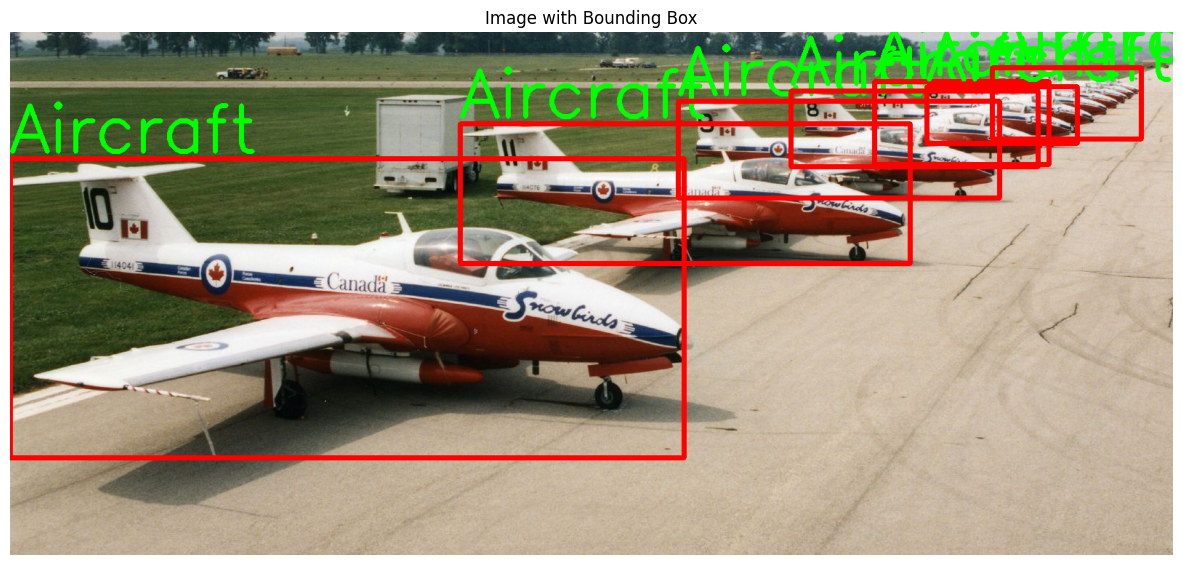

In [44]:
for img_id in train_img_ids:
  plot_bbox(img_id)

**This looks fine to me!!**

In [52]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = pd.concat([
                    test_df,
                    pd.DataFrame.from_records
                    (
                        [
                            {
                                'FileName': img_name, 
                                'XMin': row['XMin'], 
                                'XMax': row['XMax'], 
                                'YMin': row['YMin'], 
                                'YMax': row['YMax'], 
                                'ClassName': classes[i]
                            }
                        ]
                    )
                ], 
                ignore_index=True)

C:\Users\malvi\AppData\Local\Temp\ipykernel_4280\4272903116.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([


In [53]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [54]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [55]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')